In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from models import get_fire_segmentation_model, get_depth_estimation_model
import torch
from bts_eigen_v2_pytorch_densenet161 import BtsModel
from argparse import ArgumentParser

fire_detection_model = get_fire_segmentation_model()
distance_estimation_model = get_depth_estimation_model()

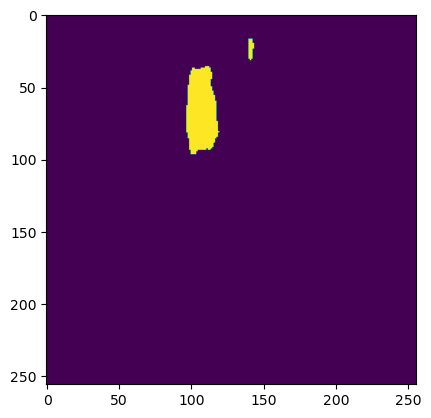

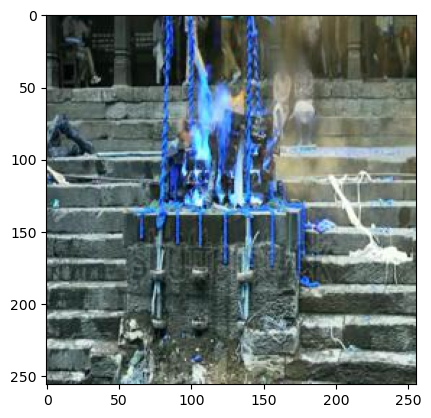

(256, 256, 1)
(256, 256, 1)


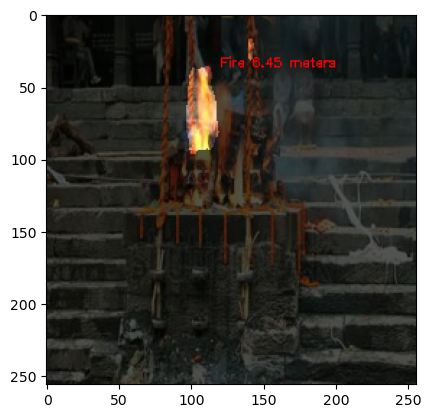

In [13]:
from GLOBAL_VARIABLES import MAX_DEPTH, MIN_DEPTH


def detect_fire(frame, fire_mask, depth_mask):
    frame = np.where(fire_mask > 0, frame, frame // 3)

    average_depth = 0

    contours__, __ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    text_x, text_y = [0, 0]
    x, y, width, height = None, None, None, None
    mask = np.zeros_like(frame)
    for __ in contours__:
        cv2.drawContours(mask, contours__, -1, 255, thickness=-1)
        c = max(contours__, key=cv2.contourArea)
        x, y, width, height = cv2.boundingRect(c)
        text_x = x + width
        text_y = y
    points = np.where(mask == 255)
    average_depth = ((np.mean(depth_mask[points]) + 1) / 2) * (MAX_DEPTH - MIN_DEPTH) + MIN_DEPTH
    # cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 1)
    # average_depth = average_depth / (sum(contour__.size for contour__ in contours__))
    cv2.putText(frame,
                text=f'Fire {average_depth:.02f} meters',
                org=(text_x, text_y),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=.3,
                color=(0, 0, 255),
                thickness=1)
    return frame

image = cv2.imread('Data/Fire Data/image/Img_0_input.jpg')
fire_mask = fire_detection_model(image[None, :, :, ::-1] / 255.)
fire_mask = np.where(fire_mask > .25, 255, 0).astype(np.uint8)[0]
plt.imshow(fire_mask)
plt.show()
plt.imshow(image)
plt.show()
depth_mask = distance_estimation_model(image[None, :, :, :] / 255.)[0]
depth_mask = np.array(depth_mask)
print(fire_mask.shape)
print(depth_mask.shape)
processed_image = detect_fire(image, fire_mask=fire_mask, depth_mask=depth_mask)
plt.imshow(processed_image[:, :, ::-1])
plt.show()